### Import required Libraries

In [1]:
import os
import re
import urllib
import pandas as pd
import matplotlib.pyplot as plt

## Preprocessing

### Helper func: Extract text w/out hyperlinks and entity-mention pairs

In [3]:
regex_expr = re.compile(r'[<«]a href="([^"]*)"(?:>)([^<]*)</a[>»]')

def process_doc(text: str) -> tuple:
    '''
        return text w/out links & link-mention pairs
    '''
    return (
        re.sub(regex_expr, r'\2' , text),
        [
            (
                urllib.parse.unquote(link[0]),
                link[1],
            )
            for link in re.findall(regex_expr, text)
        ] 
    )

### Wiki extracted dump config

In [5]:
# Wikidumps to explore
def get_datasets() -> dict:
    return {
        'elwiki-latest': {
            'lang': 'greek',
            'path': os.path.join('d:', 'elwiki-latest', 'text', 'AA'),
            'doc_info': get_stat_init_dict(),
        },
        'enwiki-latest': {
            'lang': 'english',
            'path': os.path.join('d:', 'enwiki-latest', 'text', 'AA'),
            'doc_info': get_stat_init_dict(),
        }
    }

# helper global vars
short_doc_limit = 100 #
dataset_to_explore = 'elwiki-latest'

# values to explore
def get_stat_init_dict() -> dict:
    return {
        'n_docs': 0,
        'char_count': 0,
        'href_count': 0,
        'first_paragraph_char_count': 0,
        'first_paragraph_href_count': 0,
        'mean_char_count': 0,
        'mean_href_count': 0,
        'mean_first_paragraph_char_count': 0,
        'mean_first_paragraph_href_count': 0,
        'docs_wout_href_percentage': 0,
        'extremely_short_docs_percentage': 0
    }

### Fill dataset values

In [9]:
'''
    Doc content Template:
        <doc id="{doc_id}" url="{doc_url}" title="{doc_title}">
        {doc_title}

        {first_paragraph}

        {second_paragraph}

        ...


        </doc>
'''
datasets = get_datasets()
for dataset in datasets:
    if dataset == dataset_to_explore:
        datasets[dataset]['docs'] = dict()
    for file in os.listdir(datasets[dataset]['path']):
        with open(
            os.path.join(
                datasets[dataset]['path'],
                file,
            ),
            'r',
            encoding='utf-8'
        ) as f:
            for line in f:
                if line.startswith('<doc id="'):
                    doc_lines = list()
                    curr_doc = int(
                        line[len('<doc id="') : line.find('" ')]
                    )
                elif line.startswith('</doc>'):
                    document_text, document_link_mentions_pairs = process_doc('\n'.join(doc_lines))
                    first_paragraph_text, first_paragraph_link_mentions_pairs = process_doc(doc_lines[2])
                    datasets[dataset]['doc_info']['n_docs'] += 1
                    datasets[dataset]['doc_info']['char_count'] += len(document_text)
                    datasets[dataset]['doc_info']['href_count'] += len(document_link_mentions_pairs)
                    datasets[dataset]['doc_info']['first_paragraph_char_count'] += len(first_paragraph_text)
                    datasets[dataset]['doc_info']['first_paragraph_href_count'] += len(first_paragraph_link_mentions_pairs)
                    if len(document_link_mentions_pairs) == 0:
                        datasets[dataset]['doc_info']['docs_wout_href_percentage'] += 1
                    if len(document_text) < short_doc_limit:
                        datasets[dataset]['doc_info']['extremely_short_docs_percentage'] += 1
                    if 'docs' in datasets[dataset]:
                        datasets[dataset]['docs'][curr_doc] = {
                            'char_count': len(document_text),
                            'entities': [pair[0] for pair in document_link_mentions_pairs],
                        }
                else:
                    doc_lines.append(line)
    datasets[dataset]['doc_info']['mean_char_count'] = round(
        datasets[dataset]['doc_info']['char_count'] / datasets[dataset]['doc_info']['n_docs']
        , 2
    )
    datasets[dataset]['doc_info']['mean_href_count'] = round(
        datasets[dataset]['doc_info']['href_count'] / datasets[dataset]['doc_info']['n_docs']
        , 2
    )
    datasets[dataset]['doc_info']['mean_first_paragraph_char_count'] = round(
       datasets[dataset]['doc_info']['first_paragraph_char_count'] / datasets[dataset]['doc_info']['n_docs']
        , 2
    )
    datasets[dataset]['doc_info']['mean_first_paragraph_href_count'] = round(
        datasets[dataset]['doc_info']['first_paragraph_href_count'] / datasets[dataset]['doc_info']['n_docs']
        , 2
    )
    datasets[dataset]['doc_info']['docs_wout_href_percentage'] = round(
        (datasets[dataset]['doc_info']['docs_wout_href_percentage'] / datasets[dataset]['doc_info']['n_docs']) * 100
        , 2
    )
    datasets[dataset]['doc_info']['extremely_short_docs_percentage'] = round(
        (datasets[dataset]['doc_info']['extremely_short_docs_percentage'] / datasets[dataset]['doc_info']['n_docs']) * 100
        , 2
    )
    print(f'Processed dataset: {dataset}')

Processed dataset: elwiki-latest
Processed dataset: enwiki-latest


## Results (dataset-wise)
    

In [14]:
df = pd.DataFrame.from_dict({
    dataset: datasets[dataset]['doc_info']
    for dataset in datasets
})

### Display findings

In [6]:
print(
    str(df.columns[0]).rjust(56),
    str(df.columns[1]).rjust(30),
    '\n',
)
df = df.T
for index, row in df.iteritems():
    print(
        str(index).ljust(42), 
        str(round(row[0], 2)).ljust(30),
        str(round(row[1], 2)).ljust(30),
        '\n',
    )

                                           elwiki-latest                  enwiki-latest 

n_docs                                     280980.0                       15788310.0                     

char_count                                 482920172.0                    14603911239.0                  

href_count                                 3103222.0                      108106829.0                    

first_paragraph_char_count                 59796427.0                     1641188398.0                   

first_paragraph_href_count                 834885.0                       26326614.0                     

mean_char_count                            1718.7                         924.98                         

mean_href_count                            11.04                          6.85                           

mean_first_paragraph_char_count            212.81                         103.95                         

mean_first_paragraph_href_count            2.97       

### Plot dataset comparison

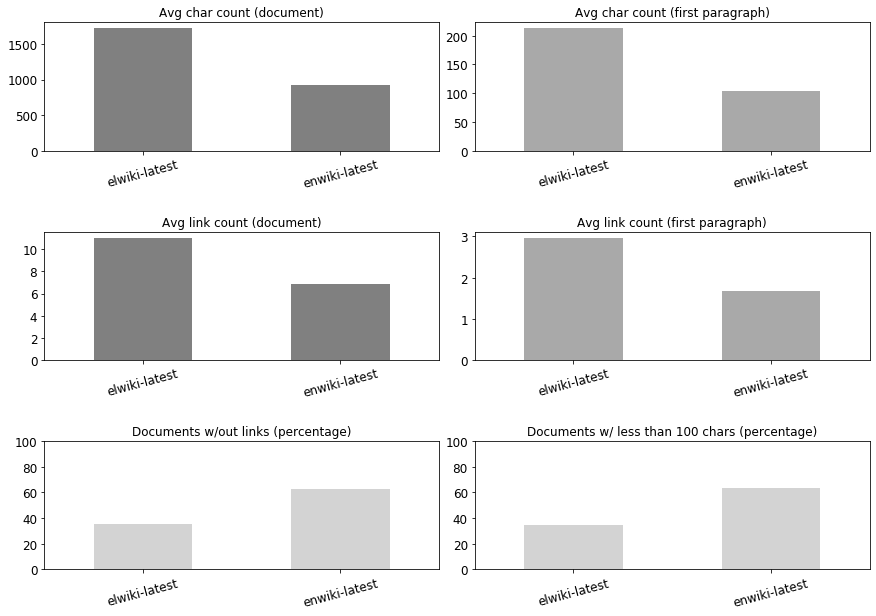

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
fig.tight_layout(
    pad=0.4, 
    w_pad=0.5,
    h_pad=6.0
)
df.mean_char_count.plot.bar(
    title = 'Avg char count (document)', 
    rot = 15, 
    color = 'grey', 
    fontsize=12,
    ax=axes[0,0]
)
df.mean_first_paragraph_char_count.plot.bar(
    title = 'Avg char count (first paragraph)', 
    rot = 15, 
    color = 'darkgrey', 
    fontsize=12,
    ax=axes[0,1]
)
df.mean_href_count.plot.bar(
    title = 'Avg link count (document)', 
    rot = 15, 
    color = 'grey', 
    fontsize=12,
    ax=axes[1,0]
)
df.mean_first_paragraph_href_count.plot.bar(
    title = 'Avg link count (first paragraph)', 
    rot = 15,
    color = 'darkgrey', 
    fontsize=12,
    ax=axes[1,1]
)
df.docs_wout_href_percentage.plot.bar(
    title = 'Documents w/out links (percentage)', 
    rot = 15, 
    color = 'lightgrey', 
    ylim = (0, 100),
    fontsize=12,
    ax=axes[2,0]
)
df.extremely_short_docs_percentage.plot.bar(
    title = 'Documents w/ less than {} chars (percentage)'.format(short_doc_limit), 
    rot = 15,
    color = 'lightgrey', 
    ylim = (0, 100),
    fontsize=12,
    ax=axes[2,1]
)
plt.show()

## Results (on "elwiki-latest" dataset)

In [8]:
df2 = pd.DataFrame.from_dict(datasets[dataset_to_explore]['docs'], orient = 'index')
df2['entity_count'] = df2.entities.apply(lambda x: len(x))

### Plot elwiki-latest results

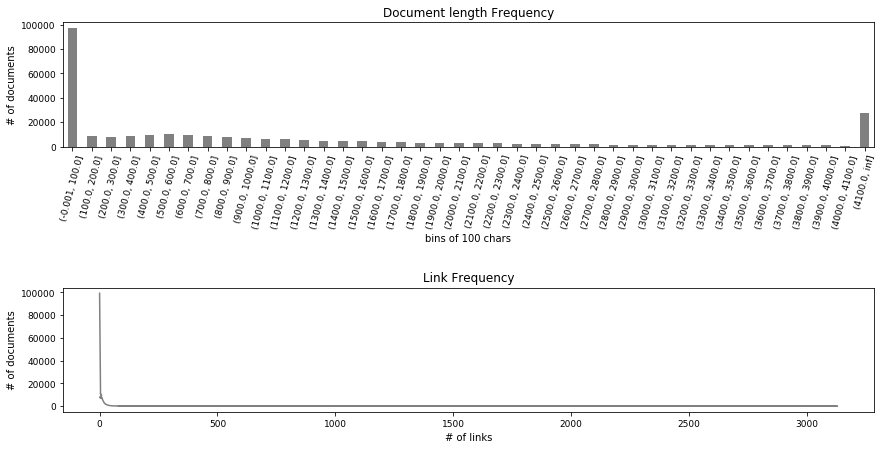

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))
fig.tight_layout(
    h_pad=12.0
)
axes[0].set_xlabel('bins of 100 chars')
axes[0].set_ylabel('# of documents')
axes[1].set_xlabel('# of links')
axes[1].set_ylabel('# of documents')
pd.cut(
    df2.char_count, 
    bins=[i for i in range(0, df2.char_count.value_counts().max(), 100)]+[float("inf")], 
    include_lowest=True
).value_counts(sort=False).plot.bar(
    title = 'Document length Frequency', 
    color = 'grey', 
    rot = 75,
    fontsize=9,
    ax=axes[0]
)
df2.entity_count.value_counts().plot(
    title = 'Link Frequency',
    color = 'grey', 
    fontsize=9,
    ax=axes[1]
)
plt.show()